# Interpret Graph GONet

## Objective
- Analyze the frequency and the sign of activation of the GO terms
- Explain the prediction of one patient

The results shown below come from the analysis of GraphGONet on the TCGA dataset. Similar results can be obtained on other datasets or with a different set of hyperparameters such as the type of selection and the ratio of selection.

#### Load libraries

In [1]:
%config Completer.use_jedi = False

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from IPython.display import HTML, Math

In [3]:
 import sys; sys.getdefaultencoding()

'utf-8'

In [4]:
import torch
import torch.nn as nn
import torch_geometric
import networkx as nx
from goatools import obo_parser

#dealing with dataset
from torchvision import transforms
from torch.utils.data import Dataset
from torch_geometric.data import Data, DataLoader

from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

import os
import pickle
import time
import sys
import json

#### Tool Functions 

In [5]:
import gc
def torch_clear_gpu_mem():
    gc.collect()
    torch.cuda.empty_cache()

#### Folders 

In [6]:
DATASET=input("Which dataset are you using? TCGA or microarray")

Which dataset are you using? TCGA or microarray TCGA


In [ ]:
dir_data = "../data"

In [ ]:
dir_files = "../files"

In [10]:
dir_log = "../log"

In [11]:
os.listdir(dir_log)

['GraphGONet_MASK=top_SELECTRATIO=0.001']

#### Choose desired model

In [136]:
dir_save = os.path.join(dir_log,"GraphGONet_SELECTOP=top_SELECTRATIO=0.001")
dir_save

'../log/GraphGONet_SELECTOP=top_SELECTRATIO=0.001'

#### Model Hyperparameters

In [14]:
with open(os.path.join(dir_save,'model_args.txt'), 'r') as fp:
    args = json.load(fp)
args.items()

dict_items([('dir_log', 'log'), ('dir_files', 'files'), ('dir_data', '/home/vbourgeais/data/RNASeq/TCGA/data_20190619/split-multi'), ('file_extension', None), ('save', True), ('restore', False), ('processing', 'train_and_evaluate'), ('type_graph', 'truncated'), ('n_samples', None), ('n_inputs', 18427), ('n_nodes', 10636), ('n_nodes_annotated', 8288), ('dim_init', 1), ('n_prop1', 1), ('n_classes', 12), ('mask', 'top'), ('selection_ratio', 0.001), ('optimizer', 'adam'), ('lr', 0.001), ('es', True), ('patience', 5), ('delta', 0.001), ('batch_size', 64), ('n_epochs', 50), ('display_step', None), ('device', 'cuda'), ('class_weight', True), ('checkpoint', 'model.pt'), ('dir_save', 'log/GraphGONet_MASK=top_SELECTRATIO=0.001'), ('learning_time', 5972.425860881805)])

In [17]:
#For the architecture
TYPE_GRAPH = args["type_graph"]
SHAPE_FEATURES = args["n_inputs"]
DIM_INITIAL = args["dim_init"]
DIM_FINAL = args["n_prop1"] 
N_GO_ANNOT = args["n_nodes_annotated"] 
N_GO = args["n_nodes"] 
N_OUTPUT = args["n_classes"]

#For the inference process
SELECT_OP = args["selection_op"]
SELECT_RATIO = args["selection_ratio"]

N_EPOCHS = args["n_epochs"]
DISPLAY_STEP = args["display_step"]

## Load dataset & data cleaning

Load useful files for the construction of the graph (probes,GO-terms)

In [18]:
start = time.time()

### Gene expression

#### Selection of the probes connected to a GO-term in our list

In [19]:
%time
mask_features = np.load(os.path.join(dir_files,"genes_annotated.npz"))["mask"]

CPU times: user 9 µs, sys: 4 µs, total: 13 µs
Wall time: 23.1 µs


#### Dataset container

In [20]:
class GeneExpressionDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, file_name,mask_features=None,transform=None,n_classes=1,class_weights=False,n_samples=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        loader =  np.load(file_name)
        self.X = loader['x'].astype('float32')
        if n_classes <2 :
            self.y = loader['y'].astype('float32')
        else:
            self.y = loader['y']
        self.transform = transform
        
        if self.y.dtype =='<U4':
            le = preprocessing.LabelEncoder()
            le.fit(self.y)
            self.y = le.transform(self.y)
            self.target_names = list(le.classes_)
        else:
            self.target_names = ["noncancer","cancer"]
            
        if mask_features is not None:
            self.X = self.X[:,mask_features]
        if n_samples:
            sss = StratifiedShuffleSplit(n_splits=1,train_size=n_samples,test_size=self.X.shape[0]-n_samples,random_state=42) #keeping the proportion of the original classes
            for train_index, test_index in sss.split(self.X , self.y):
                self.X, self.y = self.X[train_index,:], self.y[train_index]

        if class_weights:
            self.class_weight = torch.tensor(class_weight.compute_class_weight('balanced',
                                                 np.unique(self.y),
                                                 self.y).astype('float32'))

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = {'data': self.X[idx,], 'labels': self.y[idx]}
        
        if self.transform:
            sample['data'] = self.transform(sample['data'])
            sample['labels'] = torch.tensor(sample['labels'])

        return sample["data"],sample["labels"]


In [21]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, data):
        return torch.from_numpy(data)

In [22]:
%%time
testset = GeneExpressionDataset(file_name=os.path.join(dir_data,"X_test.npz"),
                                 transform=transforms.Compose([ToTensor()]),n_classes=N_OUTPUT, mask_features = mask_features)

CPU times: user 2.44 s, sys: 101 ms, total: 2.54 s
Wall time: 2.54 s


### Input graph 

#### Load the associated connection matrix

In [23]:
%%time
matrix_connection = pd.read_csv(os.path.join(dir_files,"matrix_connection_{}.csv".format(TYPE_GRAPH)),index_col=0,encoding='utf-8')
matrix_connection.head()

CPU times: user 22.7 s, sys: 481 ms, total: 23.2 s
Wall time: 23.2 s


,GO:0000002,GO:0000003,GO:0000012,GO:0000018,GO:0000019,GO:0000027,GO:0000028,GO:0000038,GO:0000045,GO:0000052,...,GO:2001207,GO:2001215,GO:2001228,GO:2001248,GO:2001262,GO:2001263,GO:2001270,GO:2001293,GO:2001302,GO:2001304
ENSG00000000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Load the truncated graph

In [24]:
matrix_connection.shape

(18427, 8288)

In [25]:
matrix_connection[matrix_connection==1].sum().sum()

115340.0

In [26]:
list_go = matrix_connection.columns

In [188]:
graph = nx.read_gpickle(os.path.join(dir_files,"gobp-{}-converted".format(TYPE_GRAPH)))

In [28]:
print(nx.info(graph))

Name: go
Type: MultiDiGraph
Number of nodes: 10636
Number of edges: 23824
Average in degree:   2.2399
Average out degree:   2.2399


In [34]:
with open(os.path.join(dir_files,'map_int_go_{}.txt'.format(TYPE_GRAPH)), 'r') as fp:
    map_int_go = json.load(fp)
map_int_go.items()

dict_items([('0', 'GO:0000002'), ('1', 'GO:0000003'), ('2', 'GO:0000012'), ('3', 'GO:0000018'), ('4', 'GO:0000019'), ('5', 'GO:0000027'), ('6', 'GO:0000028'), ('7', 'GO:0000038'), ('8', 'GO:0000045'), ('9', 'GO:0000052'), ('10', 'GO:0000054'), ('11', 'GO:0000056'), ('12', 'GO:0000070'), ('13', 'GO:0000076'), ('14', 'GO:0000077'), ('15', 'GO:0000079'), ('16', 'GO:0000082'), ('17', 'GO:0000083'), ('18', 'GO:0000086'), ('19', 'GO:0000096'), ('20', 'GO:0000097'), ('21', 'GO:0000098'), ('22', 'GO:0000117'), ('23', 'GO:0000122'), ('24', 'GO:0000154'), ('25', 'GO:0000165'), ('26', 'GO:0000183'), ('27', 'GO:0000184'), ('28', 'GO:0000186'), ('29', 'GO:0000187'), ('30', 'GO:0000188'), ('31', 'GO:0000209'), ('32', 'GO:0000212'), ('33', 'GO:0000226'), ('34', 'GO:0000245'), ('35', 'GO:0000266'), ('36', 'GO:0000272'), ('37', 'GO:0000278'), ('38', 'GO:0000281'), ('39', 'GO:0000288'), ('40', 'GO:0000289'), ('41', 'GO:0000291'), ('42', 'GO:0000296'), ('43', 'GO:0000302'), ('44', 'GO:0000303'), ('45', '

In [35]:
map_int_go={int(idx):go for idx,go in map_int_go.items()}
map_int_go

{0: 'GO:0000002',
 1: 'GO:0000003',
 2: 'GO:0000012',
 3: 'GO:0000018',
 4: 'GO:0000019',
 5: 'GO:0000027',
 6: 'GO:0000028',
 7: 'GO:0000038',
 8: 'GO:0000045',
 9: 'GO:0000052',
 10: 'GO:0000054',
 11: 'GO:0000056',
 12: 'GO:0000070',
 13: 'GO:0000076',
 14: 'GO:0000077',
 15: 'GO:0000079',
 16: 'GO:0000082',
 17: 'GO:0000083',
 18: 'GO:0000086',
 19: 'GO:0000096',
 20: 'GO:0000097',
 21: 'GO:0000098',
 22: 'GO:0000117',
 23: 'GO:0000122',
 24: 'GO:0000154',
 25: 'GO:0000165',
 26: 'GO:0000183',
 27: 'GO:0000184',
 28: 'GO:0000186',
 29: 'GO:0000187',
 30: 'GO:0000188',
 31: 'GO:0000209',
 32: 'GO:0000212',
 33: 'GO:0000226',
 34: 'GO:0000245',
 35: 'GO:0000266',
 36: 'GO:0000272',
 37: 'GO:0000278',
 38: 'GO:0000281',
 39: 'GO:0000288',
 40: 'GO:0000289',
 41: 'GO:0000291',
 42: 'GO:0000296',
 43: 'GO:0000302',
 44: 'GO:0000303',
 45: 'GO:0000305',
 46: 'GO:0000375',
 47: 'GO:0000380',
 48: 'GO:0000387',
 49: 'GO:0000398',
 50: 'GO:0000414',
 51: 'GO:0000416',
 52: 'GO:0000422',
 53

In [36]:
map_go_int={go:idx for idx,go in map_int_go.items()}
map_go_int

{'GO:0000002': 0,
 'GO:0000003': 1,
 'GO:0000012': 2,
 'GO:0000018': 3,
 'GO:0000019': 4,
 'GO:0000027': 5,
 'GO:0000028': 6,
 'GO:0000038': 7,
 'GO:0000045': 8,
 'GO:0000052': 9,
 'GO:0000054': 10,
 'GO:0000056': 11,
 'GO:0000070': 12,
 'GO:0000076': 13,
 'GO:0000077': 14,
 'GO:0000079': 15,
 'GO:0000082': 16,
 'GO:0000083': 17,
 'GO:0000086': 18,
 'GO:0000096': 19,
 'GO:0000097': 20,
 'GO:0000098': 21,
 'GO:0000117': 22,
 'GO:0000122': 23,
 'GO:0000154': 24,
 'GO:0000165': 25,
 'GO:0000183': 26,
 'GO:0000184': 27,
 'GO:0000186': 28,
 'GO:0000187': 29,
 'GO:0000188': 30,
 'GO:0000209': 31,
 'GO:0000212': 32,
 'GO:0000226': 33,
 'GO:0000245': 34,
 'GO:0000266': 35,
 'GO:0000272': 36,
 'GO:0000278': 37,
 'GO:0000281': 38,
 'GO:0000288': 39,
 'GO:0000289': 40,
 'GO:0000291': 41,
 'GO:0000296': 42,
 'GO:0000302': 43,
 'GO:0000303': 44,
 'GO:0000305': 45,
 'GO:0000375': 46,
 'GO:0000380': 47,
 'GO:0000387': 48,
 'GO:0000398': 49,
 'GO:0000414': 50,
 'GO:0000416': 51,
 'GO:0000422': 52,
 'G

In [189]:
leaves = [map_int_go[node] for node in graph.nodes if (graph.in_degree(node) == 0)]

In [190]:
leaves_idx = [node for node in graph.nodes if (graph.in_degree(node) == 0)]
leaves_idx

[5,
 6,
 7,
 13,
 15,
 17,
 22,
 28,
 29,
 30,
 6576,
 6577,
 42,
 47,
 48,
 6578,
 6579,
 51,
 6580,
 6581,
 6582,
 54,
 6583,
 56,
 57,
 58,
 61,
 6584,
 63,
 6585,
 80,
 6586,
 84,
 6587,
 6588,
 87,
 6589,
 6590,
 6591,
 6592,
 88,
 6593,
 101,
 104,
 107,
 112,
 6594,
 128,
 6595,
 160,
 161,
 6596,
 168,
 6597,
 170,
 6598,
 6599,
 180,
 181,
 190,
 6600,
 202,
 204,
 6601,
 211,
 212,
 213,
 214,
 6602,
 220,
 221,
 229,
 230,
 233,
 236,
 6603,
 6604,
 241,
 6605,
 6606,
 247,
 253,
 254,
 255,
 259,
 267,
 268,
 270,
 272,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 6607,
 282,
 290,
 6608,
 6609,
 303,
 304,
 305,
 6610,
 6611,
 317,
 320,
 6612,
 6613,
 323,
 329,
 6614,
 6615,
 6616,
 6617,
 343,
 6618,
 6619,
 359,
 6620,
 6621,
 6622,
 366,
 372,
 6623,
 377,
 379,
 382,
 6624,
 6625,
 6626,
 383,
 6627,
 6628,
 384,
 385,
 6629,
 6630,
 6631,
 6632,
 391,
 393,
 394,
 399,
 400,
 6633,
 411,
 421,
 422,
 6634,
 424,
 425,
 6635,
 6636,
 437,
 6637,
 6638,
 6639,
 446,
 44

In [43]:
%%time
df_go_level=pd.read_csv(os.path.join(dir_files,"go_to_level_{}.csv".format(TYPE_GRAPH)),index_col=0,encoding='utf-8')

CPU times: user 5.84 ms, sys: 127 µs, total: 5.97 ms
Wall time: 5.36 ms


In [44]:
df_go_level.head()

,root,d+,d-
GO:0000002,6,1,1
GO:0000003,1,1,4
GO:0000012,8,1,3
GO:0000018,8,2,8
GO:0000019,9,2,2


In [45]:
go_obo = os.path.join(dir_files,'go-basic.obo')
go = obo_parser.GODag(go_obo)

../files/go-basic.obo: fmt(1.2) rel(2020-06-01) 47,233 GO Terms


#### Convert the graph to a Graph Tensor

In [46]:
def from_networkx(G,dim_inital_node_embedding,label,random=False):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
        label (list): Label of patient's outcome. (binary(scalar): 0/1)
        dim_inital_node_embedding (int): Here 1, initialized to 0 and will be updated latter after applying the first module.
        random (bool, optional): generate random embeddings for nodes without GO annotations. The samples share the same initial graph.
    """

    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.tensor(list(G.edges(data=False))).t().contiguous()

    data = {}

    data['edge_index'] = edge_index.view(2, -1)
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()
    if random:
        data.x = torch.cat((torch.zeros(len(list_go),dim_inital_node_embedding),torch.randn(data.num_nodes-len(list_go), dim_inital_node_embedding)),0)
    else: 
        data.x = torch.zeros(data.num_nodes, dim_inital_node_embedding)
    #initialize the nodes without direct GO annotations to a random value in a gaussian
    
    #all the parameters of the class Data are optional. Here, the parameters edge_attr,pos,normal,face are set to None.

    return data

In [47]:
graph = from_networkx(graph,dim_inital_node_embedding=DIM_INITIAL,label=N_OUTPUT)

Checking

In [49]:
graph.contains_isolated_nodes()

False

In [50]:
graph.contains_self_loops()

False

In [51]:
graph.is_directed()

True

#### Create a graph for each sample  

In [54]:
n_samples = testset.X.shape[0]
data_list = [graph.clone() for i in np.arange(n_samples)]

In [55]:
end = time.time()
elapsed=end - start
print("Total time: {}h {}min {}sec".format(time.gmtime(elapsed).tm_hour,
time.gmtime(elapsed).tm_min,
time.gmtime(elapsed).tm_sec))

Total time: 0h 3min 9sec


## Define the architecture

In [56]:
from typing import Union, Tuple, Callable, Optional
from torch_geometric.typing import OptPairTensor, Adj, Size, OptTensor
from torch import Tensor
from torch.nn import Linear, Parameter
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_scatter import scatter,scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.pool.topk_pool import topk, filter_adj

In [59]:
class DAGProp(torch.nn.Module):
    r"""
    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
        out_channels (int): Size of each output sample.
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        nonlinearity (torch.nn.functional, optional): The nonlinearity to use.
            (default: :obj:`torch.tanh`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, root_weight: bool = True,
                 bias: bool = True, nonlinearity: Callable = torch.tanh, aggr: str = "mean",**kwargs):
        super(DAGProp, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.root_weight = root_weight
        self.nonlinearity = nonlinearity
        self.aggr = aggr

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = Linear(in_channels[0], out_channels, bias=bias)
        if self.root_weight:
            self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()

    def forward(self, x: Tensor, edge_index: Adj, batch: OptTensor = None , 
                size: Size = None) -> Tensor:
        num_nodes = scatter_add(batch.new_ones(x.size(0),dtype=torch.int16), batch, dim=0)
        batch_size, max_num_nodes = num_nodes.size(0), num_nodes.max().item()
        num_edges_ref = edge_index.shape[1] // batch_size
        
        out = x.new_zeros(x.size())
        visited = x.new_zeros(size=(x.size(0),),dtype=torch.int16) 

        #1. Start propagation from the leaves

        leaves = torch.where(scatter(src=edge_index.new_ones(edge_index[1,:].size(),dtype=torch.int8),
                            index=edge_index[1,:], reduce="sum")==0)[0]
        out[leaves] = self.nonlinearity(x[leaves])
        visited[leaves]=1
        
        #2. Compute self-nodes processing (case: N_{x_{v}}!=0)

        if self.root_weight:
            temp = x[leaves]
            x[leaves] = 0
            mask = x.nonzero(as_tuple=True)[0]
            x[leaves] = temp
            out[mask] = self.lin_r(x[mask]) 
        
        #3. Update the embedding of the other nodes 
        
        previous_visits = leaves[leaves < max_num_nodes]
        adj_mat_cropped = edge_index[:,:num_edges_ref]
        while torch.sum(visited)!=visited.shape[0]: 
            mask=(adj_mat_cropped[0,:][..., None] == previous_visits).any(-1)
            fathers = torch.unique(adj_mat_cropped[1,mask])
            del mask
            mask=(adj_mat_cropped[1,:][..., None]== fathers).any(-1)
            mask1=scatter(src=visited[adj_mat_cropped[0,mask]], index=adj_mat_cropped[1,mask], reduce="sum")
            mask1=mask1[fathers]
            mask2=scatter(src=visited.new_ones(size=visited[adj_mat_cropped[0,mask]].size(),dtype=torch.int16), index=adj_mat_cropped[1,mask], reduce="sum")
            mask2=mask2[fathers]
            ref_next_visits = fathers[mask1==mask2]
            del mask
            mask = (adj_mat_cropped[1,:][..., None] == ref_next_visits).any(-1) 
            adj_mat = [adj_mat_cropped[:,mask] + i*max_num_nodes for i in range(batch_size)]
            adj_mat = torch.cat(adj_mat, dim=1)
            next_visits = [ref_next_visits + i*max_num_nodes for i in range(batch_size)]
            next_visits = torch.cat(next_visits, dim=0)
            mask = adj_mat[0,:]
            children = out[mask].view(-1)
            out[next_visits] += self.lin_l(scatter(src=children,index=adj_mat[1,:],reduce=self.aggr)[next_visits][:,None])
            out[next_visits] = self.nonlinearity(out[next_visits])
            previous_visits = ref_next_visits
            visited[next_visits]=1

        return out

    def __repr__(self):
        return '{}({}, {}, aggr={}, nonlinearity={})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels,self.aggr,self.nonlinearity.__name__)

In [58]:
class TopSelection(torch.nn.Module):
    def __init__(self, in_channels: int, ratio: Union[float, int] = 0.5, **kwargs):
        super(TopSelection, self).__init__()

        self.in_channels = in_channels
        self.ratio = ratio

    def forward(self, x, edge_index, edge_attr=None, batch=None):
        if batch is None:
            batch = edge_index.new_zeros(x.size(0))
        
        perm = topk(torch.abs(x).view(-1), self.ratio, batch)
        num_nodes = x.size(0)
        x = x[perm]
        batch = batch[perm]
        edge_index, edge_attr = filter_adj(edge_index, edge_attr, perm,
                                           num_nodes=num_nodes)
        return x, edge_index, edge_attr, batch, perm, x

    def __repr__(self):
        return '{}({}, ratio={})'.format(
            self.__class__.__name__, 
            self.in_channels,
            self.ratio)

In [57]:
class RandomSelection(torch.nn.Module):
    def __init__(self, in_channels: int, ratio: Union[float, int] = 0.5, **kwargs):
        super(RandomSelection, self).__init__()

        self.in_channels = in_channels
        self.ratio = ratio

    def forward(self, x, edge_index, edge_attr=None, batch=None, attn=None):
        if batch is None:
            batch = edge_index.new_zeros(x.size(0))
        max_num_nodes = scatter_add(batch.new_ones(x.size(0),dtype=torch.int16), batch, dim=0).max().item()  
        perm = [torch.sort(torch.randperm(max_num_nodes,dtype=torch.long, device=x.device)[:ceil(max_num_nodes*self.ratio)]+k*max_num_nodes,descending=False)[0] for k in torch.unique(batch)]
        perm = torch.cat(perm, dim=0)
        num_nodes = x.size(0)
        x = x[perm]
        batch = batch[perm]
        edge_index, edge_attr = filter_adj(edge_index, edge_attr, perm, num_nodes = num_nodes)

        return x, edge_index, edge_attr, batch, perm, x

    def __repr__(self):
        return '{}({}, ratio={})'.format(
            self.__class__.__name__, 
            self.in_channels,
            self.ratio)

In [69]:
def concatenate(x: Tensor, batch: Tensor, size: Optional[int] = None) -> Tensor:
    batch_size = int(batch.max().item() + 1) if size is None else size
    return x.view(batch_size,-1)

def concatenate_and_mask(x: Tensor, batch: Tensor, idx_nodes_kept : Tensor, num_nodes : Tensor) -> Tensor:
    num_nodes_kept = scatter_add(batch.new_ones(x.size(0),dtype=torch.int16), batch, dim=0)
    batch_size, max_num_nodes = num_nodes_kept.size(0), num_nodes.max().item()
    output = x.new_zeros((batch_size,max_num_nodes)) 
    for i in torch.arange(batch_size):
        mask = idx_nodes_kept[i*num_nodes_kept[i]:(i+1)*num_nodes_kept[i]] - i*num_nodes[i]
        output[i,mask]=x[i*num_nodes_kept[i]:(i+1)*num_nodes_kept[i]].view(-1)
    return output

class Mask(torch.nn.Module):
    def __init__(self, in_channels, method, n_nodes, **kwargs):
        super(Mask, self).__init__()
        self.method = method
        self.in_channels = in_channels
        if self.method.__name__ == "global_mean_pool": 
            self.out_neurons=1
        else:
            self.out_neurons=n_nodes

    def forward(self, *args):
        return self.method(*args)
        
    def __repr__(self):
        return '{}({}, {}, method={})'.format(
            self.__class__.__name__,
            self.out_neurons,
            self.in_channels,
            self.method.__name__)

In [133]:
class Net(torch.nn.Module):
    def __init__(self,n_genes,n_nodes,n_nodes_annot,n_nodes_emb,n_prop1,n_classes,adj_mat_fc1,
                 propagation="DAGProp",selection=None,ratio=1.0,
                 mask="concatenate_and_mask"):
        super(Net, self).__init__()
        self.n_genes = n_genes
        self.n_nodes = n_nodes
        self.n_nodes_annot = n_nodes_annot
        self.n_nodes_emb = n_nodes_emb
        self.n_prop1 = n_prop1
        self.n_classes = n_classes
        adj_mat_fc1 = torch.tensor(adj_mat_fc1, dtype=torch.float).t()
        self.adj_mat_fc1 = Parameter(adj_mat_fc1, requires_grad=False)
        self.fc1 = Linear(in_features=n_genes,out_features=n_nodes_annot)
        with torch.no_grad():
            self.fc1.weight.mul_(self.adj_mat_fc1)
        self.propagation = eval(propagation)(in_channels=n_nodes_emb, out_channels=n_prop1,aggr = "mean")
        if selection:
            self.ratio = ratio
            if selection=="random":
                self.selection = RandomSelection(in_channels=n_prop1,ratio=ratio)
            elif selection=="top":
                self.selection = TopSelection(in_channels=n_prop1,ratio=ratio)
        else:
            mask="concatenate"
        self.mask = Mask(method=globals()[mask],in_channels=n_prop1,n_nodes=n_nodes) 
        self.fc2 = Linear(in_features=n_nodes,out_features=n_classes)

    def forward(self,transcriptomic_data,graph_data):
        x, edge_index, batch = graph_data.x, graph_data.edge_index, graph_data.batch
        initial_embedding = self.fc1(transcriptomic_data)
        for k in np.arange(graph_data.num_graphs): 
            x[self.n_nodes*k:self.n_nodes*k+self.n_nodes_annot]=initial_embedding[k].unsqueeze_(1)
        x = self.propagation(x, edge_index,batch)
        
        num_nodes = scatter_add(batch.new_ones(x.size(0),dtype=torch.int16), batch, dim=0)
        
        if self.selection: 
            x, edge_index, _, batch,idx_nodes_kept,_ = self.selection(x, edge_index, None, batch)
        
        if self.mask.method.__name__ == "concatenate_and_mask":
            x = self.mask(x,batch,idx_nodes_kept,num_nodes)
        else:
            x = self.mask(x,batch)
            
        x = self.fc2(x)
        
        if self.n_classes >=2:
            return x
        else:
            return x.view(-1)

In [128]:
def model_forward(batchGE, batchGraph):
    batchGraph=batchGraph.to(device)
    out = model(transcriptomic_data=batchGE, graph_data=batchGraph)
    return out

In [129]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [130]:
def get_pool(name):
    def hook(model, input, output):
        activation[name] = {}
        activation[name]["output"] = output[0].detach()
        activation[name]["edge_index"] = output[1].detach()
        activation[name]["idx_top_nodes"] = output[4].detach()
    return hook

In [131]:
def get_accuracy(y_true, y_pred):
    return int(np.sum(np.equal(y_true,y_pred))) / y_true.shape[0]

## Load the saved model

In [137]:
%%time
device = torch.device('cpu') #cuda
model = Net(n_genes=SHAPE_FEATURES,n_nodes=N_GO,n_nodes_annot=N_GO_ANNOT,n_nodes_emb=DIM_INITIAL,n_classes=N_OUTPUT,n_prop1=DIM_FINAL,adj_mat_fc1=matrix_connection.values,
            selection=SELECT_OP,ratio=SELECT_RATIO)
model.load_state_dict(torch.load(os.path.join(dir_save,args["checkpoint"]), map_location=device))
model.eval()

CPU times: user 2.12 s, sys: 614 ms, total: 2.74 s
Wall time: 1.35 s


Net(
  (fc1): Linear(in_features=18427, out_features=8288, bias=True)
  (propagation): DAGProp(1, 1, aggr=mean, nonlinearity=tanh)
  (selection): TopSelection(1, ratio=0.001)
  (mask): Mask(10636, 1, method=concatenate_and_mask)
  (fc2): Linear(in_features=10636, out_features=12, bias=True)
)

In [138]:
BATCH_SIZE = testset.y.shape[0] #args["batch_size"]
BATCH_SIZE 

1293

In [139]:
%%time
testloaderGraph = DataLoader(data_list, batch_size=BATCH_SIZE,shuffle=False)

CPU times: user 59 µs, sys: 6 µs, total: 65 µs
Wall time: 68.2 µs


In [140]:
%%time
testloaderGE = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=0)

CPU times: user 51 µs, sys: 0 ns, total: 51 µs
Wall time: 53.6 µs


In [141]:
from captum.attr import LayerGradientXActivation

In [142]:
layer_ga = LayerGradientXActivation(model_forward, model.mask)#model

In [143]:
batchGE,labels=next(iter(testloaderGE))
batchGraph=next(iter(testloaderGraph))
activation = {}
model.eval()
with torch.no_grad():
    model.mask.register_forward_hook(get_activation('mask'))
    output = model(transcriptomic_data=batchGE,graph_data=batchGraph)
    if N_OUTPUT >=2:
        prob = torch.nn.Softmax(dim=1)(output)
        pred = prob.argmax(axis=1)
    else:
        prob = torch.sigmoid(output)
        pred = (output>0.5)
    print(pred.float())
    print(labels)

tensor([0., 6., 7.,  ..., 7., 2., 2.])
tensor([0, 6, 7,  ..., 9, 2, 2])


In [144]:
%%time
batchGE=batchGE.requires_grad_(True).to(device)
if DATASET=="TCGA":
    attribution = layer_ga.attribute(inputs=batchGE,target=pred,additional_forward_args=(batchGraph,))
else:
    attribution = layer_ga.attribute(inputs=batchGE,additional_forward_args=(batchGraph,))

CPU times: user 16.8 s, sys: 2.69 s, total: 19.5 s
Wall time: 5.58 s


In [145]:
pred.shape

torch.Size([1293])

In [146]:
get_accuracy(labels.numpy(), pred.numpy())

0.9489559164733179

In [148]:
activation_map_mask = activation['mask'].view([BATCH_SIZE,-1])
activation_map_mask.shape

torch.Size([1293, 10636])

In [149]:
if DATASET=="TCGA":
    map_idx_class = {idx : label for idx,label in enumerate(testset.target_names)}
else:
    map_idx_class = {idx : label for idx,label in enumerate(testset.target_names)}

## Explain response type

### Study the frequency and the sign of neurons for a given class

In [150]:
first_index = np.array([[id_go]*2 for id_go in map_int_go.values()]).reshape(-1)
second_index = ["+","-"]*N_GO

In [151]:
df_map_sign = pd.DataFrame(np.zeros((testset.X.shape[0],first_index.shape[0]),dtype=np.int8),index=np.arange(testset.X.shape[0]),columns=[first_index, second_index])
df_map_sign.head()

GO:0000002    GO:0000003    GO:0000012    GO:0000018    GO:0000019     ...  \
           +  -          +  -          +  -          +  -          +  -  ...   
0          0  0          0  0          0  0          0  0          0  0  ...   
1          0  0          0  0          0  0          0  0          0  0  ...   
2          0  0          0  0          0  0          0  0          0  0  ...   
3          0  0          0  0          0  0          0  0          0  0  ...   
4          0  0          0  0          0  0          0  0          0  0  ...   

  GO:2001197    GO:2001233    GO:2001267    GO:2001279    GO:2001300     
           +  -          +  -          +  -          +  -          +  -  
0          0  0          0  0          0  0          0  0          0  0  
1          0  0          0  0          0  0          0  0          0  0  
2          0  0          0  0          0  0          0  0          0  0  
3          0  0          0  0          0  0          0  0          0  0  
4          0  0          0  0          0  0          0  0          0  0  

[5 rows x 21272 columns]

In [152]:
%%time
for n in np.arange(testset.X.shape[0]):
    print("Processing sample {}".format(n))
    for idx_go,id_go in map_int_go.items():
        sign_go = np.sign(activation_map_mask[n,idx_go])
        if sign_go==-1:
            df_map_sign.loc[n,(id_go,"-")]= 1
        elif sign_go==1:
            df_map_sign.loc[n,(id_go,"+")]= 1

Processing sample 0
Processing sample 1
Processing sample 2
Processing sample 3
Processing sample 4
Processing sample 5
Processing sample 6
Processing sample 7
Processing sample 8
Processing sample 9
Processing sample 10
Processing sample 11
Processing sample 12
Processing sample 13
Processing sample 14
Processing sample 15
Processing sample 16
Processing sample 17
Processing sample 18
Processing sample 19
Processing sample 20
Processing sample 21
Processing sample 22
Processing sample 23
Processing sample 24
Processing sample 25
Processing sample 26
Processing sample 27
Processing sample 28
Processing sample 29
Processing sample 30
Processing sample 31
Processing sample 32
Processing sample 33
Processing sample 34
Processing sample 35
Processing sample 36
Processing sample 37
Processing sample 38
Processing sample 39
Processing sample 40
Processing sample 41
Processing sample 42
Processing sample 43
Processing sample 44
Processing sample 45
Processing sample 46
Processing sample 47
Pr

In [154]:
if DATASET=="TCGA":
    df_map_sign["class"]=[map_idx_class[pred_class.item()] for pred_class in pred.numpy()]
else:
    df_map_sign["class"]=pred.numpy()
    df_map_sign.loc[df_map_sign["class"]==1,("class",)]="cancer"
    df_map_sign.loc[df_map_sign["class"]==0,("class",)]="noncancer"

In [155]:
df_map_sign.head()

GO:0000002    GO:0000003    GO:0000012    GO:0000018    GO:0000019     ...  \
           +  -          +  -          +  -          +  -          +  -  ...   
0          0  0          0  0          0  0          0  0          0  0  ...   
1          0  0          0  0          0  0          0  0          0  0  ...   
2          0  0          0  0          0  0          0  0          0  0  ...   
3          0  0          0  0          0  0          0  0          0  0  ...   
4          0  0          0  0          0  0          0  0          0  0  ...   

  GO:2001197 GO:2001233    GO:2001267    GO:2001279    GO:2001300    class  
           -          +  -          +  -          +  -          +  -        
0          0          0  0          0  0          0  0          0  0  BRCA  
1          0          0  0          0  0          0  0          0  0  LUSC  
2          0          0  0          0  0          0  0          0  0    NT  
3          0          0  0          0  0          0  0          0  0  THCA  
4          0          0  0          0  0          0  0          0  0  THCA  

[5 rows x 21273 columns]

In [104]:
df_map_sign.to_csv(os.path.join(dir_save,"sign_map_ref.csv"))

In [156]:
gp = df_map_sign.groupby(by="class")

In [157]:
gp.aggregate("sum")

/nhome/siniac/vbourgeais/venv-pytorch/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


GO:0000002      GO:0000003      GO:0000012      GO:0000018       \
               +    -          +    -          +    -          +    -   
class                                                                   
BRCA         0.0  0.0        0.0  0.0        0.0  0.0        0.0  0.0   
HNSC         0.0  0.0        0.0  0.0        0.0  0.0        0.0  0.0   
KIRC         0.0  0.0        0.0  0.0        0.0  0.0        0.0  0.0   
LGG          0.0  0.0        0.0  0.0        0.0  0.0        0.0  0.0   
LIHC         0.0  0.0        0.0  0.0        0.0  0.0        0.0  0.0   
LUAD         0.0  0.0        0.0  0.0        0.0  0.0        0.0  0.0   
LUSC         0.0  0.0        0.0  0.0        0.0  0.0        0.0  0.0   
NT           0.0  0.0        0.0  0.0        0.0  0.0        0.0  0.0   
OV           0.0  0.0        0.0  0.0        0.0  0.0        0.0  0.0   
PRAD         0.0  0.0        0.0  0.0        0.0  0.0        0.0  0.0   
THCA         0.0  0.0        0.0  0.0        0.0  0.0        0.0  0.0   
UCEC         0.0  0.0        0.0  0.0        0.0  0.0        0.0  0.0   

      GO:0000019       ... GO:2001197      GO:2001233      GO:2001267       \
               +    -  ...          +    -          +    -          +    -   
class                  ...                                                   
BRCA         0.0  0.0  ...        0.0  0.0        0.0  0.0        0.0  0.0   
HNSC         0.0  0.0  ...        0.0  0.0        0.0  0.0        0.0  0.0   
KIRC         0.0  0.0  ...        0.0  0.0        0.0  0.0        0.0  0.0   
LGG          0.0  0.0  ...        0.0  0.0        0.0  0.0        0.0  0.0   
LIHC         0.0  0.0  ...        0.0  0.0        0.0  0.0        0.0  0.0   
LUAD         0.0  0.0  ...        0.0  0.0        0.0  0.0        0.0  0.0   
LUSC         0.0  0.0  ...        0.0  0.0        0.0  0.0        0.0  0.0   
NT           0.0  0.0  ...        0.0  0.0        0.0  0.0        0.0  0.0   
OV           0.0  0.0  ...        0.0  0.0        0.0  0.0        0.0  0.0   
PRAD         0.0  0.0  ...        0.0  0.0        0.0  0.0        0.0  0.0   
THCA         0.0  0.0  ...        0.0  0.0        0.0  0.0        0.0  0.0   
UCEC         0.0  0.0  ...        0.0  0.0        0.0  0.0        0.0  0.0   

      GO:2001279      GO:2001300       
               +    -          +    -  
class                                  
BRCA         0.0  0.0        0.0  0.0  
HNSC         0.0  0.0        0.0  0.0  
KIRC         0.0  0.0        0.0  0.0  
LGG          0.0  0.0        0.0  0.0  
LIHC         0.0  0.0        0.0  0.0  
LUAD         0.0  0.0        0.0  0.0  
LUSC         0.0  0.0        0.0  0.0  
NT           0.0  0.0        0.0  0.0  
OV           0.0  0.0        0.0  0.0  
PRAD         0.0  0.0        0.0  0.0  
THCA         0.0  0.0        0.0  0.0  
UCEC         0.0  0.0        0.0  0.0  

[12 rows x 21272 columns]

In [158]:
group="BRCA"

In [159]:
gp.get_group(group).aggregate("sum")

GO:0000002  +                                                    0
            -                                                    0
GO:0000003  +                                                    0
            -                                                    0
GO:0000012  +                                                    0
                                       ...                        
GO:2001279  +                                                    0
            -                                                    0
GO:2001300  +                                                    0
            -                                                    0
class            BRCABRCABRCABRCABRCABRCABRCABRCABRCABRCABRCABR...
Length: 21273, dtype: object

In [163]:
rankFreqClass = gp.get_group(group).sum(level=0,axis=1).sum(axis=0)[0:N_GO].sort_values(ascending=False)
rankFreqClass[:10]

GO:0043312    186
GO:0021795    172
GO:0016239    151
GO:0007608    148
GO:0031076    131
GO:0021987    127
GO:0021952    122
GO:0001654    120
GO:0048048    118
GO:0021955    112
dtype: object

In [164]:
temp_freq = gp.get_group(group).aggregate("sum")
temp_freq

GO:0000002  +                                                    0
            -                                                    0
GO:0000003  +                                                    0
            -                                                    0
GO:0000012  +                                                    0
                                       ...                        
GO:2001279  +                                                    0
            -                                                    0
GO:2001300  +                                                    0
            -                                                    0
class            BRCABRCABRCABRCABRCABRCABRCABRCABRCABRCABRCABR...
Length: 21273, dtype: object

In [165]:
rankFreqClass=pd.DataFrame(rankFreqClass,columns=["total"])
rankFreqClass.head()

,total
GO:0043312,186
GO:0021795,172
GO:0016239,151
GO:0007608,148
GO:0031076,131


In [166]:
rankFreqClass["+"]=[temp_freq[(id_go,'+')] for id_go in rankFreqClass.index]
rankFreqClass["-"]=[temp_freq[(id_go,'-')] for id_go in rankFreqClass.index]

In [167]:
rankFreqClass=rankFreqClass[:10]

In [168]:
rankFreqClass.reset_index(inplace=True)
rankFreqClass.rename(columns={"index":"id_go"},inplace=True)

In [169]:
rankFreqClass.head()

,id_go,total,+,-
0,GO:0043312,186,186,0
1,GO:0021795,172,0,172
2,GO:0016239,151,0,151
3,GO:0007608,148,141,7
4,GO:0031076,131,0,131


Text(0.5, 1.0, 'BRCA predicted samples')

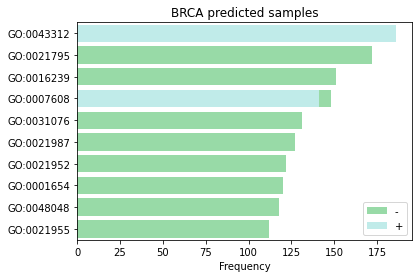

In [170]:
sns.set_color_codes("pastel")
sns.barplot(x="total", y="id_go", data=rankFreqClass,
            label="-", color="g")

sns.set_color_codes("pastel")
sns.barplot(x="+", y="id_go", data=rankFreqClass,
            label="+", color="c")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("")
plt.title("{} predicted samples".format(group))

## Explain patients' prediction

### Study of a cancer sample

In [171]:
output_idx=testset.target_names.index(group)

In [172]:
list_idx_samples_correct = np.where((labels==output_idx) & (pred==output_idx))[0]
list_idx_samples_correct

array([   0,    5,    7,    9,   10,   14,   17,   18,   20,   31,   33,
         35,   51,   55,   56,   57,   58,   77,   84,   94,   99,  115,
        116,  117,  120,  122,  126,  129,  136,  143,  145,  151,  157,
        158,  176,  182,  183,  188,  195,  200,  201,  203,  214,  220,
        229,  246,  247,  248,  279,  284,  285,  287,  298,  308,  321,
        323,  326,  340,  341,  347,  350,  358,  361,  365,  375,  376,
        377,  379,  387,  405,  412,  416,  420,  428,  431,  433,  439,
        440,  446,  447,  449,  458,  460,  461,  464,  470,  476,  478,
        484,  495,  526,  528,  533,  538,  547,  555,  558,  566,  573,
        587,  589,  597,  607,  618,  622,  627,  628,  631,  642,  645,
        648,  664,  667,  677,  683,  688,  693,  700,  701,  703,  706,
        707,  708,  713,  723,  725,  738,  740,  749,  752,  756,  763,
        767,  776,  786,  787,  796,  798,  810,  836,  840,  848,  851,
        855,  859,  873,  884,  890,  892,  906,  9

In [173]:
k=list_idx_samples_correct[0]

In [206]:
labels[k].item()

0

In [207]:
pred[k].item()

0

In [208]:
if DATASET=="TCGA":
    print(prob[k][output_idx].item())
else:
    prob[k].item()

0.9079324007034302


In [205]:
print("Total Relevance Score:")
if DATASET=="TCGA":
    print(output[k][output_idx].item())
else:
    output[k].item()

Total Relevance Score:
4.343381404876709


In [177]:
mask = torch.nonzero(attribution[k].detach(),as_tuple=True)
mask

(tensor([ 621, 1737, 3292, 3851, 4095, 4801, 5284, 5764, 6014, 6088, 7896]),)

In [178]:
list_go_selected = [map_int_go[idx] for idx in mask[0].numpy()]
list_go_selected

['GO:0006110',
 'GO:0016239',
 'GO:0043369',
 'GO:0048048',
 'GO:0050772',
 'GO:0061299',
 'GO:0072540',
 'GO:1901030',
 'GO:1903146',
 'GO:1903599',
 'GO:1903859']

In [179]:
saliency_map = pd.DataFrame(data=torch.stack((attribution[k][mask],activation_map_mask[k][mask],model.fc2.weight[0,mask[0]]),1).detach().numpy(),columns=["R_i","a_i","w_i"],index=list_go_selected)
saliency_map

,R_i,a_i,w_i
GO:0006110,0.996477,0.999380,0.997095
GO:0016239,0.564338,-0.991162,-0.569370
GO:0043369,0.617839,-0.995978,-0.620333
GO:0048048,0.521239,-0.987862,-0.527643
GO:0050772,0.082287,-0.990137,-0.083107
GO:0061299,0.381856,0.998117,0.382576
GO:0072540,0.400612,-0.999796,-0.400693
GO:1901030,0.194902,-0.996723,-0.195542
GO:1903146,-0.124681,-0.990907,0.125825
GO:1903599,-0.054196,-0.989441,0.054774


Number of nodes with negative contribution:

In [180]:
np.sum(saliency_map["R_i"]<0)

2

In [181]:
np.sum(saliency_map["R_i"]<0)/saliency_map.shape[0]*100

18.181818181818183

In [182]:
rank = saliency_map.sort_values(by=["R_i","a_i"],ascending=False)
rank

,R_i,a_i,w_i
GO:0006110,0.996477,0.999380,0.997095
GO:1903859,0.923161,0.993871,0.928854
GO:0043369,0.617839,-0.995978,-0.620333
GO:0016239,0.564338,-0.991162,-0.569370
GO:0048048,0.521239,-0.987862,-0.527643
GO:0072540,0.400612,-0.999796,-0.400693
GO:0061299,0.381856,0.998117,0.382576
GO:1901030,0.194902,-0.996723,-0.195542
GO:0050772,0.082287,-0.990137,-0.083107
GO:1903599,-0.054196,-0.989441,0.054774


In [183]:
rank["R_i"] = np.round(rank["R_i"],decimals=2)
rank

,R_i,a_i,w_i
GO:0006110,1.00,0.999380,0.997095
GO:1903859,0.92,0.993871,0.928854
GO:0043369,0.62,-0.995978,-0.620333
GO:0016239,0.56,-0.991162,-0.569370
GO:0048048,0.52,-0.987862,-0.527643
GO:0072540,0.40,-0.999796,-0.400693
GO:0061299,0.38,0.998117,0.382576
GO:1901030,0.19,-0.996723,-0.195542
GO:0050772,0.08,-0.990137,-0.083107
GO:1903599,-0.05,-0.989441,0.054774


Number of leaves:

In [191]:
len(set(rank.index) & set(leaves))

3

In [192]:
len(set(rank.index) & set(leaves))/rank.shape[0]*100

27.27272727272727

In [193]:
for idx_go in rank.index:
    print(go[idx_go])

GO:0006110	level-05	depth-09	regulation of glycolytic process [biological_process]
GO:1903859	level-05	depth-09	regulation of dendrite extension [biological_process]
GO:0043369	level-05	depth-05	CD4-positive or CD8-positive, alpha-beta T cell lineage commitment [biological_process]
GO:0016239	level-08	depth-08	positive regulation of macroautophagy [biological_process]
GO:0048048	level-05	depth-06	embryonic eye morphogenesis [biological_process]
GO:0072540	level-08	depth-08	T-helper 17 cell lineage commitment [biological_process]
GO:0061299	level-03	depth-03	retina vasculature morphogenesis in camera-type eye [biological_process]
GO:1901030	level-05	depth-09	positive regulation of mitochondrial outer membrane permeabilization involved in apoptotic signaling pathway [biological_process]
GO:0050772	level-08	depth-10	positive regulation of axonogenesis [biological_process]
GO:1903599	level-08	depth-08	positive regulation of autophagy of mitochondrion [biological_process]
GO:1903146	level-0

In [200]:
dfTopGO = pd.DataFrame(index=rank.index)
dfTopGO['desc']=np.asarray([go[go_id].name for go_id in rank.index])
dfTopGO['relevance']= rank["R_i"]
dfTopGO['weight']= np.round(rank["w_i"],decimals=2)
dfTopGO['sign']= ["deeppink" if rank.loc[go,"R_i"]>0 else "royalblue" for go in dfTopGO.index]

In [201]:
dfTopGO

,desc,relevance,weight,sign
GO:0006110,regulation of glycolytic process,1.00,1.00,deeppink
GO:1903859,regulation of dendrite extension,0.92,0.93,deeppink
GO:0043369,"CD4-positive or CD8-positive, alpha-beta T cel...",0.62,-0.62,deeppink
GO:0016239,positive regulation of macroautophagy,0.56,-0.57,deeppink
GO:0048048,embryonic eye morphogenesis,0.52,-0.53,deeppink
GO:0072540,T-helper 17 cell lineage commitment,0.40,-0.40,deeppink
GO:0061299,retina vasculature morphogenesis in camera-typ...,0.38,0.38,deeppink
GO:1901030,positive regulation of mitochondrial outer mem...,0.19,-0.20,deeppink
GO:0050772,positive regulation of axonogenesis,0.08,-0.08,deeppink
GO:1903599,positive regulation of autophagy of mitochondrion,-0.05,0.05,royalblue


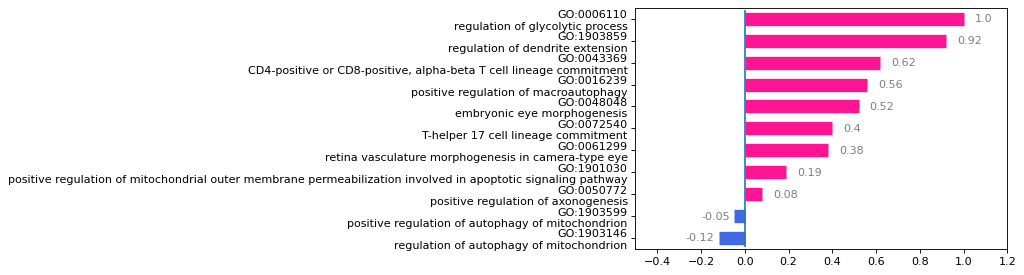

In [202]:
import matplotlib.patches as mpatches

plt.figure(figsize=(6,4), dpi= 80)
for idx_go in dfTopGO.index:
    if dfTopGO.loc[idx_go,"relevance"]>0:
        plt.hlines(y=dfTopGO.loc[idx_go,"desc"], xmin=0, xmax=dfTopGO.loc[idx_go,"relevance"], colors=dfTopGO.loc[idx_go,"sign"],linewidth=12)
    else:
        plt.hlines(y=dfTopGO.loc[idx_go,"desc"], xmin=dfTopGO.loc[idx_go,"relevance"], xmax=0, colors=dfTopGO.loc[idx_go,"sign"],linewidth=12)
plt.vlines(x=0,ymin=10.4, ymax=-0.4)

for x, y in zip(dfTopGO.relevance, dfTopGO.desc):
    if x<0:
        t = plt.text(x-0.15 ,y, "{}".format(round(x, 2)),verticalalignment='center', color="C7")
    else:
        t = plt.text(x+0.05, y, "{}".format(round(x, 2)), verticalalignment='center',color="C7")

loc,_=plt.yticks()
plt.yticks(loc,
           ["{}\n{}".format(i,j) for i,j in zip(dfTopGO.index,dfTopGO.desc)])
plt.margins(0.01)
plt.xlim(left=-0.5,right=1.2)
plt.gca().invert_yaxis()